In [1]:
import sys

print(sys.executable)

C:\Users\dkreu\anaconda3\python.exe


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from tensorflow import keras
import pint

%matplotlib notebook

In [3]:
# IMPORT NEURAL NETWORK MODELS

H_model0 = keras.models.load_model("best_model_dndE_CloudTuner.h5")
H_Emax_model = keras.models.load_model("best_tuned_model_Emax.h5")

In [4]:
# Trying to build VEGA 3 laser
# Format such that parameters can pass through NN-models

inputs0 = np.array(
    [
        [
            30 / 50,
            20e-6
            / 20e-6,  # FWHM of focus spot estimated from G .Claps et al 2020 JINST 15 C02006
            30e-15 / 150e-15,
            1,
            12.2 / 85.0,
            800e-9 / 1100e-9,
            2e-6 / 3e-6,
        ]
    ]
)

In [5]:
inputs0.shape

(1, 7)

In [6]:
inputs = inputs0.copy()
# Prepare models for plotting


def H_model(x):
    return H_model0(np.insert(inputs, 0, x).reshape((1, 8))).numpy().flatten()


H_model = np.vectorize(H_model)
H_Emax = H_Emax_model(inputs).numpy().flatten()[0]

In [7]:
H_Emax

13.768044

In [8]:
thin = inputs0.copy()
thin[0, 6] = 3e-6 / 3e-6
H_Emax_model(thin).numpy().flatten()[0]

16.359665

<IPython.core.display.Javascript object>


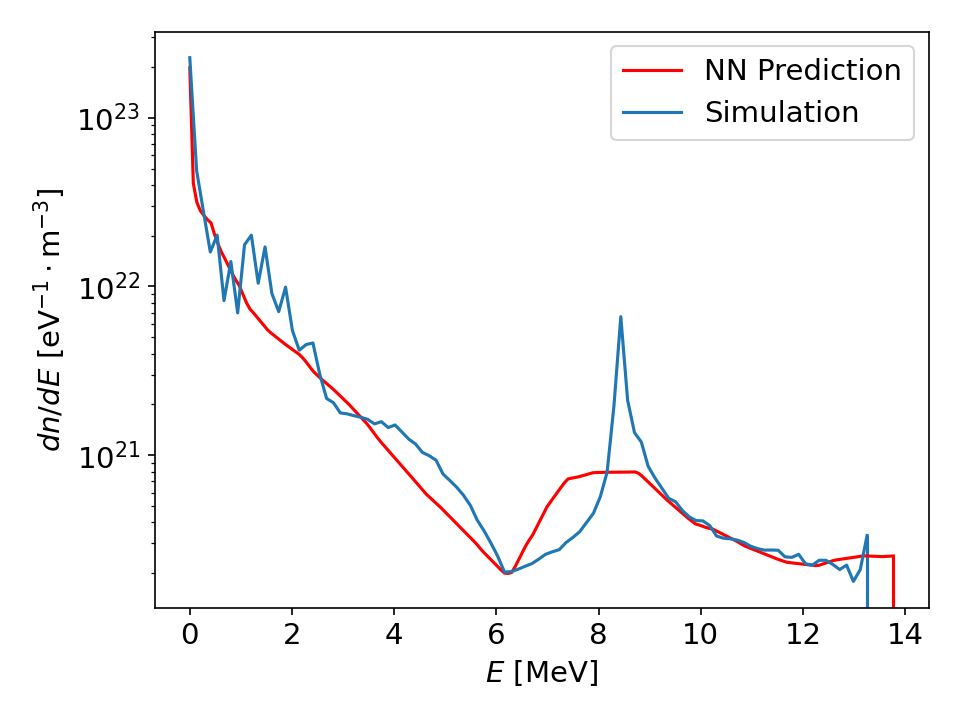

In [9]:
inputs = inputs0.copy()

vega_init_sim = np.load("../vega_init/vega_init_h.npy")

plt.figure(dpi=150)
plt.rcParams["font.size"] = "14"
x = np.linspace(0, H_Emax, 200)
x_sim = np.linspace(0, 1, 100)
plt.plot(x, np.exp(H_model(x)), color="red", label="NN Prediction")
plt.plot(x_sim * vega_init_sim[-1], np.exp(vega_init_sim[:-1]), label="Simulation")
plt.vlines(H_Emax, ymin=0, ymax=np.exp(H_model(H_Emax)), color="red")
plt.vlines(vega_init_sim[-1], ymin=0, ymax=np.exp(vega_init_sim[-2]))
plt.legend()
plt.yscale("log")
plt.ylabel("$dn/dE$ [eV${}^{-1}\cdot$m${}^{-3}$]")
plt.xlabel("$E$ [MeV]")
# plt.title("Predicted Energy Spectrum - Accelerated Hydrogen Ions")
plt.tight_layout()
# plt.show
# plt.savefig("VEGA3-H-Spectrum.pdf")

In [10]:
inputs = inputs0.copy()
# FUNCTIONS FOR OPTIMISATION


def full_en_int(params_no_E, E):
    """
    Delivers the energy intergral for a given combination of inputs
    """
    parametercombi = E_switch(params_no_E, E)
    bound = model_emax(parametercombi).numpy().flatten()[0]
    return integrate.quad(
        lambda x: np.exp(
            model_func(np.insert(parametercombi, 0, x).reshape((1, 8)))
            .numpy()
            .flatten()[0]
            - 50
        )
        * x,
        0,
        bound,
        limit=1000,
    )[0]


def E_switch(params_no_E, E):
    parametercombi = np.append(params_no_E, E)
    return np.roll(parametercombi, 1).reshape((1, 7))


def geometryfactor(FWHM):
    """
    function to convert a FWHM value to the 2 sigma area
    Assumption is the cylinder symmetry of the laserpulse
    """
    import numpy as np

    # r = (np.sqrt(2/np.log(2))*FWHM)/2
    r = FWHM / np.sqrt(2 * np.log(2))
    return np.pi * r**2


def E0fromE(tau, L, E):
    """
    function to obtain E0 from E, tau, L

    """
    const = (
        1.37e18
        * ureg.watt
        / ureg.centimeter**2
        * ureg.micrometer**2
        * ureg.elementary_charge**2
        / 4
        / np.pi**2
        / ureg.speed_of_light**4
        / ureg.electron_mass**2
    )
    return np.sqrt(E / (tau * geometryfactor(L) * const))


ureg = pint.UnitRegistry(system="SI")


def a0(E, FWHM, Tau, Lambda):
    a0_dimensional = (
        ureg.elementary_charge
        * E0fromE(
            Tau * ureg.seconds * 150e-15, FWHM * ureg.meter * 20e-6, E * ureg.joule * 50
        )
        / ureg.electron_mass
        * Lambda
        * ureg.meter
        * 1100e-9
        / (2 * np.pi)
        / ureg.speed_of_light**2
    )
    return a0_dimensional.to_base_units().magnitude

In [11]:
inputs = inputs0.copy()

a0(inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 5])

7.178810671928399

In [12]:
inputs = inputs0.copy()
# FIRST TASK:
# Optimise E_max by varying the incidence angle


def H_Emax_Opt(theta):  # Function to minimise
    params = inputs.copy()
    params[0, 4] = theta / 85.0
    return -H_Emax_model(params).numpy().flatten()[0]


optimize.minimize_scalar(H_Emax_Opt)

# DONE

     fun: -20.030647
    nfev: 32
     nit: 22
 success: True
       x: 26.77614953366583

In [13]:
inputs = inputs0.copy()
# SECOND TASK:
# Optimise E_max by varying Focus-FWHM, Pulselength, Theta, Target Thickness
# The parameters should not leave their "realistic" bounds --> EDIT: Bounds off
# a0 should stay constant


def H_Emax_Opt(x):
    FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0, 1] = FWHM
    params[0, 2] = Tau
    params[0, 4] = Theta
    params[0, 6] = d_T
    return -H_Emax_model(params).numpy().flatten()[0]


bnds = ((2e-6 / 20e-6, 1), (15e-15 / 150e-15, 1), (0, 1), (0.6e-6 / 3e-6, 1))
cons = {
    "type": "eq",
    "fun": lambda x: a0(inputs[0, 0], x[0], x[1], inputs[0, 5])
    - a0(inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 5]),
}
param_begin = [inputs[0, 1], inputs[0, 2], inputs[0, 4], inputs[0, 6]]

res = optimize.minimize(
    H_Emax_Opt,
    param_begin,
    method="trust-constr",
    bounds=bnds,
    constraints=cons,
    tol=1e-15,
    options={"disp": True, "maxiter": 5000},
)
print("--- Comparison of Fit and Initial Parameters ---")
print(
    "Initial: FWHM =",
    inputs0[0, 1] * 20,
    "µm, Tau =",
    inputs0[0, 2] * 150,
    "fs, Theta =",
    inputs0[0, 4] * 85,
    "°, d_T =",
    inputs0[0, 6] * 3,
    "µm",
)
print(
    "Fit: FWHM =",
    res.x[0] * 20,
    "µm, Tau =",
    res.x[1] * 150,
    "fs, Theta =",
    res.x[2] * 85,
    "°, d_T =",
    res.x[3] * 3,
    "µm",
)
print(
    "Maximum predicted energy initially: ",
    -H_Emax_Opt([inputs0[0, 1], inputs0[0, 2], inputs0[0, 4], inputs0[0, 6]]),
    "MeV",
)
print("Maximum predicted energy fit: ", -H_Emax_Opt(res.x), "MeV")
# DONE

C:\Users\dkreu\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 972, function evaluations: 9000, CG iterations: 1143, optimality: 1.79e+00, constraint violation: 0.00e+00, execution time: 3.2e+01 s.
--- Comparison of Fit and Initial Parameters ---
Initial: FWHM = 20.0 µm, Tau = 30.0 fs, Theta = 12.2 °, d_T = 2.0 µm
Fit: FWHM = 8.983224690257433 µm, Tau = 148.70196965968105 fs, Theta = 34.003160433954726 °, d_T = 2.9679679031584327 µm
Maximum predicted energy initially:  13.768044 MeV
Maximum predicted energy fit:  50.592735 MeV


In [14]:
# LMFIT attempt, so far unsucessful?

inputs = inputs0.copy()
from lmfit import minimize, Parameters


def H_Emax_Opt(params):
    E = params["E"]
    FWHM = params["fwhm"]
    Tau = params["tau"]
    Pol = params["pol"]
    Theta = params["theta"]
    WaveL = params["lambda_L"]
    d_T = params["d_T"]

    model_input = np.array([E, FWHM, Tau, Pol, Theta, WaveL, d_T]).reshape(1, 7)

    return np.full(4, 100 - H_Emax_model(model_input).numpy().flatten()[0])


params = Parameters()
params.add("E", value=inputs[0, 0], vary=False, min=1e-3 / 50, max=1.0)
params.add("fwhm", value=inputs[0, 1], max=1.0, min=2 / 20)
params.add("tau", value=inputs[0, 2], max=1.0, min=15 / 150)
params.add("pol", value=inputs[0, 3], vary=False)
params.add("theta", value=inputs[0, 4], max=1.0, min=0)
params.add("lambda_L", value=inputs[0, 5], vary=False, max=1.0, min=550 / 1100)
params.add("d_T", value=inputs[0, 6], max=1.0, min=0.6 / 3)

minimize(H_Emax_Opt, params)

In [15]:
inputs

array([[0.6       , 1.        , 0.2       , 1.        , 0.14352941,
        0.72727273, 0.66666667]])

In [16]:
format(inputs0[0, 2], ".60g")

'0.200000000000000011102230246251565404236316680908203125'

In [17]:
inputs = inputs0.copy()
# THIRD TASK:
# Optimise E_max by varying everything except polarisation and wavelength
# The parameters should not leave their "realistic" bounds
# a0 should stay constant


def H_Emax_Opt(x):
    E, FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0, 0] = E
    params[0, 1] = FWHM
    params[0, 2] = Tau
    params[0, 4] = Theta
    params[0, 6] = d_T
    return -H_Emax_model(params).numpy().flatten()[0]


bnds = (
    (1e-3 / 50, 1),
    (2e-6 / 20e-6, 1),
    (15e-15 / 150e-15, 1),
    (0, 1),
    (0.6e-6 / 3e-6, 1),
)
cons = {
    "type": "eq",
    "fun": lambda x: a0(x[0], x[1], x[2], inputs[0, 5])
    - a0(inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 5]),
}
param_begin = [inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 4], inputs[0, 6]]

rese = optimize.minimize(
    H_Emax_Opt,
    param_begin,
    method="trust-constr",
    bounds=bnds,
    constraints=cons,
    tol=1e-15,
    options={"disp": True, "maxiter": 5000},
)
print("--- Comparison of Fit and Initial Parameters ---")
print(
    "Initial: E =",
    inputs[0, 0] * 50,
    "J, FWHM =",
    inputs0[0, 1] * 20,
    "µm, Tau =",
    inputs0[0, 2] * 150,
    "fs, Theta =",
    inputs0[0, 4] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    inputs0[0, 6] * 3,
    "µm",
)
print(
    "Fit: E =",
    rese.x[0] * 50,
    "J, FWHM =",
    rese.x[1] * 20,
    "µm, Tau =",
    rese.x[2] * 150,
    "fs, Theta =",
    rese.x[3] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    rese.x[4] * 3,
    "µm",
)
print(
    "Maximum predicted energy initially: ",
    -H_Emax_Opt(
        [inputs0[0, 0], inputs0[0, 1], inputs0[0, 2], inputs0[0, 4], inputs0[0, 6]]
    ),
    "MeV",
)
print("Maximum predicted energy fit: ", -H_Emax_Opt(rese.x), "MeV")
# DONE

`xtol` termination condition is satisfied.
Number of iterations: 899, function evaluations: 10068, CG iterations: 1208, optimality: 2.12e+00, constraint violation: 0.00e+00, execution time: 3.3e+01 s.
--- Comparison of Fit and Initial Parameters ---
Initial: E = 30.0 J, FWHM = 20.0 µm, Tau = 30.0 fs, Theta = 12.2 °, Lambda_L = 799.9999999999999 nm, d_T = 2.0 µm
Fit: E = 6.58576484776278 J, FWHM = 4.192767177163365 µm, Tau = 149.8527500139353 fs, Theta = 32.23593146952939 °, Lambda_L = 799.9999999999999 nm, d_T = 2.9549641522825603 µm
Maximum predicted energy initially:  13.768044 MeV
Maximum predicted energy fit:  51.495567 MeV


In [18]:
np.insert(res.x, 3, 1.0)

array([0.44916123, 0.99134646, 0.40003718, 1.        , 0.98932263])

<IPython.core.display.Javascript object>


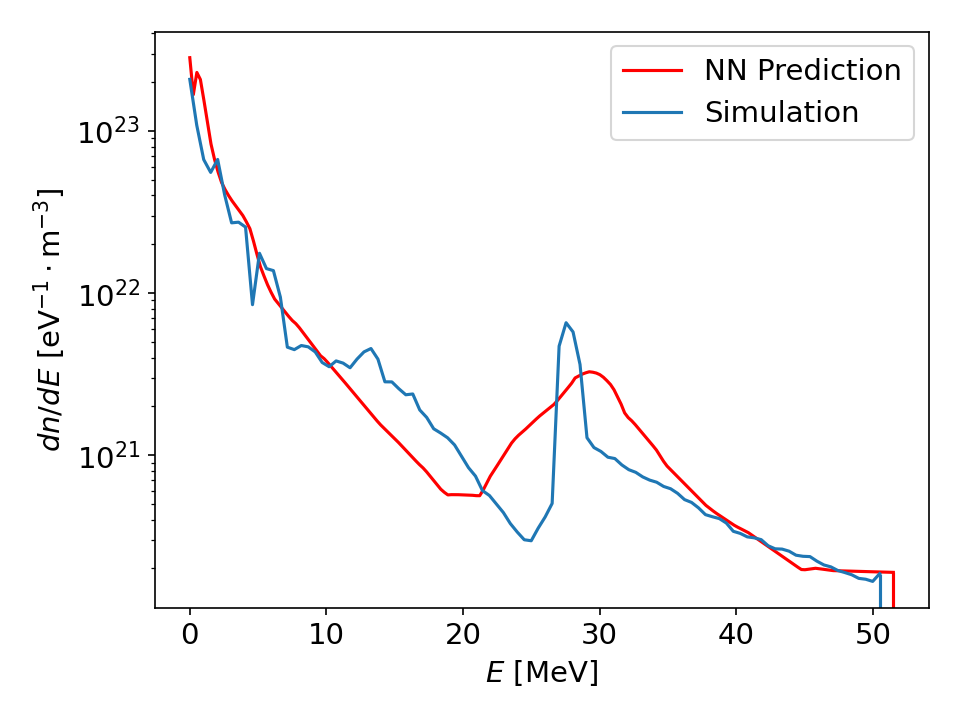

In [19]:
inputs = inputs0.copy()

new_inputs = np.insert(rese.x, 3, 1.0)
new_inputs = np.insert(new_inputs, 5, inputs[0, 5])


def H_model_opt(x):
    return H_model0(np.insert(new_inputs, 0, x).reshape((1, 8))).numpy().flatten()


H_model_opt = np.vectorize(H_model_opt)

vega_emax = np.load("../vega_emax/vega_emax_h.npy")

plt.figure(dpi=150)
plt.rcParams["font.size"] = "14"
x = np.linspace(0, -H_Emax_Opt(rese.x), 200)
x_sim = np.linspace(0, 1, 100)
plt.plot(x, np.exp(H_model_opt(x)), color="red", label="NN Prediction")
plt.vlines(
    -H_Emax_Opt(rese.x),
    ymin=0,
    ymax=np.exp(H_model_opt(-H_Emax_Opt(rese.x))),
    color="red",
)
plt.plot(x_sim * vega_emax[-1], np.exp(vega_emax[:-1]), label="Simulation")
plt.vlines(vega_emax[-1], ymin=0, ymax=np.exp(vega_emax[-2]))
plt.legend()
plt.yscale("log")
plt.ylabel("$dn/dE$ [eV${}^{-1}\cdot$m${}^{-3}$]")
plt.xlabel("$E$ [MeV]")
# plt.title("Predicted Optimised Energy Spectrum - Accelerated Hydrogen Ions")
plt.tight_layout()
# plt.show
# plt.savefig("VEGA3-H-Spectrum-Emax.pdf")

inputs = inputs0.copy()
# FOURTH TASK:
# Optimisation of Integral Int[(dn/dE)*E,{0,E_max}]
# The parameters should not leave their "realistic" bounds
# a0 should stay constant

def H_E_Int_Opt(x):
    E, FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0,0] = E
    params[0,1] = FWHM
    params[0,2] = Tau
    params[0,4] = Theta
    params[0,6] = d_T
    emax = H_Emax_model(params).numpy().flatten()[0]
    return -integrate.quad(lambda y: np.exp(H_model0(np.insert(params, 0, y).reshape((1,8))).numpy().flatten()[0]-np.log(1e18)) * y, 0, emax)[0]/E

bnds = ((1e-3/50,1),(2e-6/20e-6, 1),(15e-15/150e-15,1),(0,1), (0.6e-6/3e-6,1))
cons = ({'type': 'eq', 'fun': lambda x:  a0(x[0],x[1],x[2],inputs[0,5])-a0(inputs[0,0],inputs[0,1],inputs[0,2],inputs[0,5])})
param_begin = [inputs[0,0],inputs[0,1],inputs[0,2],inputs[0,4],inputs[0,6]]

res = optimize.minimize(H_E_Int_Opt, param_begin, method='trust-constr', bounds=bnds, constraints=cons, tol=1e-15, options={"disp":True})
print("--- Comparison of Fit and Initial Parameters ---")
print("Initial: E =",inputs[0,0]*50,"J, FWHM =",inputs0[0,1]*20,"µm, Tau =",inputs0[0,2]*150,"fs, Theta =",inputs0[0,4]*85,"°, Lambda_L =",inputs[0,5]*1100,"nm, d_T =",inputs0[0,6]*3,"µm")
print("Fit: E =",res.x[0]*50,"J, FWHM =",res.x[1]*20,"µm, Tau =",res.x[2]*150,"fs, Theta =",res.x[3]*85,"°, Lambda_L =",inputs[0,5]*1100,"nm, d_T =",res.x[4]*3,"µm")
print("Maximum predicted energy initially: ", -H_Emax_Opt([inputs0[0,0],inputs0[0,1],inputs0[0,2],inputs0[0,4],inputs0[0,6]]),"MeV")
print("Maximum predicted energy fit: ", -H_Emax_Opt(res.x),"MeV")

In [20]:
np.linspace(0, 10, num=11, endpoint=True)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [21]:
# SAME TASK BUT IN NUMPY
# MAXIMUM ENERGY PARAMETERS AS INITIAL

inputs = inputs0.copy()
# FOURTH TASK:
# Optimisation of Integral Int[(dn/dE)*E,{0,E_max}]
# The parameters should not leave their "realistic" bounds
# a0 should stay constant


def H_E_Int_Opt(x):
    E, FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0, 0] = E
    params[0, 1] = FWHM
    params[0, 2] = Tau
    params[0, 4] = Theta
    params[0, 6] = d_T
    emax = H_Emax_model(params).numpy().flatten()[0]
    ens = np.linspace(0, emax, num=1500, endpoint=True)
    xs = np.empty((len(ens), 8))
    xs[:, 0] = ens
    xs[:, 1:] = params
    return -np.trapz(np.exp(H_model0(xs).numpy().flatten()) * ens, x=ens) / E


bnds = (
    (1e-3 / 50, 1),
    (2e-6 / 20e-6, 1),
    (15e-15 / 150e-15, 1),
    (0, 1),
    (0.6e-6 / 3e-6, 1),
)
cons = {
    "type": "eq",
    "fun": lambda x: a0(x[0], x[1], x[2], inputs[0, 5])
    - a0(inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 5]),
}
param_begin = rese.x

resi = optimize.minimize(
    H_E_Int_Opt,
    param_begin,
    method="trust-constr",
    bounds=bnds,
    constraints=cons,
    tol=1e-15,
    options={"disp": True, "maxiter": 10000},
)
print("--- Comparison of Fit and Initial Parameters ---")
print(
    "Initial: E =",
    inputs[0, 0] * 50,
    "J, FWHM =",
    inputs0[0, 1] * 20,
    "µm, Tau =",
    inputs0[0, 2] * 150,
    "fs, Theta =",
    inputs0[0, 4] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    inputs0[0, 6] * 3,
    "µm",
)
print(
    "Fit: E =",
    resi.x[0] * 50,
    "J, FWHM =",
    resi.x[1] * 20,
    "µm, Tau =",
    resi.x[2] * 150,
    "fs, Theta =",
    resi.x[3] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    resi.x[4] * 3,
    "µm",
)
print(
    "Maximum predicted energy initially: ",
    -H_Emax_Opt(
        [inputs0[0, 0], inputs0[0, 1], inputs0[0, 2], inputs0[0, 4], inputs0[0, 6]]
    ),
    "MeV",
)
print("Maximum predicted energy fit: ", -H_Emax_Opt(resi.x), "MeV")
print("Predicted conversion initially: ", -H_E_Int_Opt(rese.x))
print("Predicted conversion fit: ", -H_E_Int_Opt(resi.x))  #

# DONE
# THIS RESULT IS USED IN THE THESIS

C:\Users\dkreu\anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 8359, function evaluations: 53298, CG iterations: 32027, optimality: 2.00e+23, constraint violation: 0.00e+00, execution time: 9.5e+02 s.
--- Comparison of Fit and Initial Parameters ---
Initial: E = 30.0 J, FWHM = 20.0 µm, Tau = 30.0 fs, Theta = 12.2 °, Lambda_L = 799.9999999999999 nm, d_T = 2.0 µm
Fit: E = 1.3756534196366004 J, FWHM = 2.0000000309007766 µm, Tau = 137.56533771278418 fs, Theta = 29.250219442848167 °, Lambda_L = 799.9999999999999 nm, d_T = 2.9819737687162315 µm
Maximum predicted energy initially:  13.768044 MeV
Maximum predicted energy fit:  51.173508 MeV
Predicted conversion initially:  1.5105976519899798e+25
Predicted conversion fit:  7.9923921746886e+25


In [45]:
# SAME TASK BUT IN NUMPY

inputs = inputs0.copy()
# FOURTH TASK:
# Optimisation of Integral Int[(dn/dE)*E,{0,E_max}]
# The parameters should not leave their "realistic" bounds
# a0 should stay constant


def H_E_Int_Opt(x):
    E, FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0, 0] = E
    params[0, 1] = FWHM
    params[0, 2] = Tau
    params[0, 4] = Theta
    params[0, 6] = d_T
    emax = H_Emax_model(params).numpy().flatten()[0]
    ens = np.linspace(0, emax, num=1800, endpoint=True)
    xs = np.empty((len(ens), 8))
    xs[:, 0] = ens
    xs[:, 1:] = params
    return -np.trapz(np.exp(H_model0(xs).numpy().flatten()) * ens, x=ens) / E


bnds = (
    (1e-3 / 50, 1),
    (2e-6 / 20e-6, 1),
    (15e-15 / 150e-15, 1),
    (0, 1),
    (0.6e-6 / 3e-6, 1),
)
cons = {
    "type": "eq",
    "fun": lambda x: a0(x[0], x[1], x[2], inputs[0, 5])
    - a0(inputs[0, 0], inputs[0, 1], inputs[0, 2], inputs[0, 5]),
}
param_begin = rese.x

resi = optimize.minimize(
    H_E_Int_Opt,
    param_begin,
    method="trust-constr",
    bounds=bnds,
    constraints=cons,
    tol=1e-15,
    options={"disp": True, "maxiter": 100000},
)
print("--- Comparison of Fit and Initial Parameters ---")
print(
    "Initial: E =",
    inputs[0, 0] * 50,
    "J, FWHM =",
    inputs0[0, 1] * 20,
    "µm, Tau =",
    inputs0[0, 2] * 150,
    "fs, Theta =",
    inputs0[0, 4] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    inputs0[0, 6] * 3,
    "µm",
)
print(
    "Fit: E =",
    resi.x[0] * 50,
    "J, FWHM =",
    resi.x[1] * 20,
    "µm, Tau =",
    resi.x[2] * 150,
    "fs, Theta =",
    resi.x[3] * 85,
    "°, Lambda_L =",
    inputs[0, 5] * 1100,
    "nm, d_T =",
    resi.x[4] * 3,
    "µm",
)
print(
    "Maximum predicted energy initially: ",
    -H_Emax_Opt(
        [inputs0[0, 0], inputs0[0, 1], inputs0[0, 2], inputs0[0, 4], inputs0[0, 6]]
    ),
    "MeV",
)
print("Maximum predicted energy fit: ", -H_Emax_Opt(resi.x), "MeV")
print("Predicted conversion initially: ", -H_E_Int_Opt(rese.x))
print("Predicted conversion fit: ", -H_E_Int_Opt(resi.x))

`xtol` termination condition is satisfied.
Number of iterations: 1089, function evaluations: 10158, CG iterations: 1989, optimality: 6.17e+23, constraint violation: 1.34e-13, execution time: 2.3e+02 s.
--- Comparison of Fit and Initial Parameters ---
Initial: E = 30.0 J, FWHM = 20.0 µm, Tau = 30.0 fs, Theta = 12.2 °, Lambda_L = 799.9999999999999 nm, d_T = 2.0 µm
Fit: E = 6.109416569418667 J, FWHM = 4.03630745246569 µm, Tau = 149.99999693974755 fs, Theta = 31.0203773215657 °, Lambda_L = 799.9999999999999 nm, d_T = 2.9684742502171395 µm
Maximum predicted energy initially:  13.768044 MeV
Maximum predicted energy fit:  50.192173 MeV
Predicted conversion initially:  1.5106032993238653e+25
Predicted conversion fit:  1.5845092135618055e+25


<IPython.core.display.Javascript object>


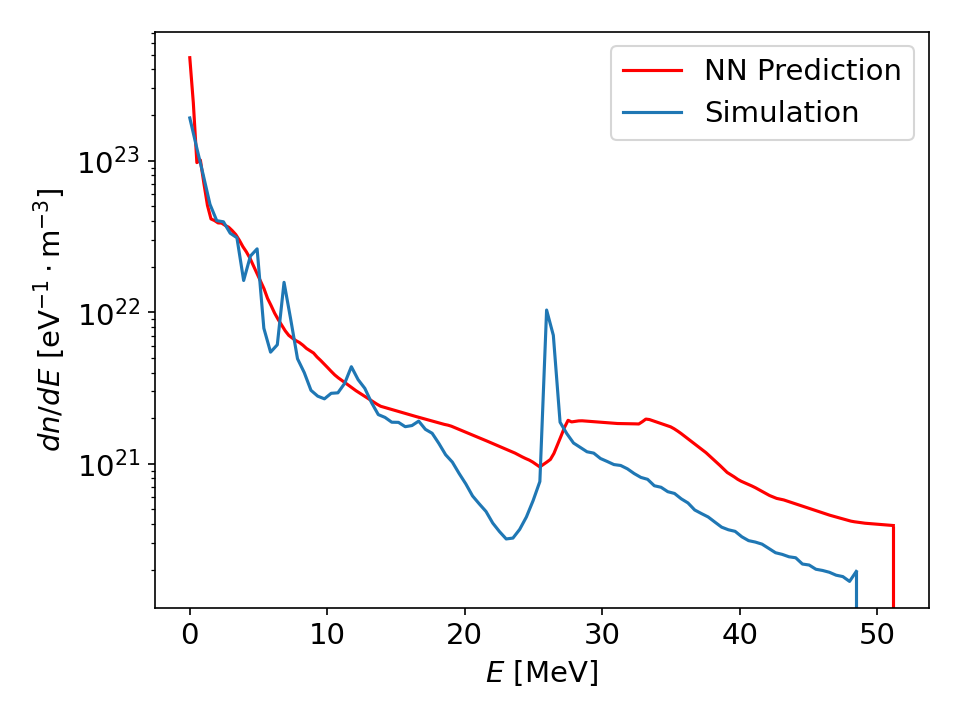

In [25]:
inputs = inputs0.copy()

new_inputs = np.insert(resi.x, 3, 1.0)
new_inputs = np.insert(new_inputs, 5, inputs[0, 5])


def H_model_opt(x):
    return H_model0(np.insert(new_inputs, 0, x).reshape((1, 8))).numpy().flatten()


H_model_opt = np.vectorize(H_model_opt)

vega_emax = np.load("../vega_econv/vega_econv_h.npy")

plt.figure(dpi=150)
plt.rcParams["font.size"] = "14"
x = np.linspace(0, -H_Emax_Opt(resi.x), 200)
x_sim = np.linspace(0, 1, 100)
plt.plot(x, np.exp(H_model_opt(x)), color="red", label="NN Prediction")
plt.vlines(
    -H_Emax_Opt(resi.x),
    ymin=0,
    ymax=np.exp(H_model_opt(-H_Emax_Opt(resi.x))),
    color="red",
)
plt.plot(x_sim * vega_emax[-1], np.exp(vega_emax[:-1]), label="Simulation")
plt.vlines(vega_emax[-1], ymin=0, ymax=np.exp(vega_emax[-2]))
plt.legend()
plt.yscale("log")
plt.ylabel("$dn/dE$ [eV${}^{-1}\cdot$m${}^{-3}$]")
plt.xlabel("$E$ [MeV]")
# plt.title("Predicted Optimised Energy Spectrum - Accelerated Hydrogen Ions")
plt.tight_layout()
# plt.show
# plt.savefig("VEGA3-H-Spectrum-Econv.pdf")

In [ ]:
inputs0

In [47]:
def H_E_Int_Opt(x):
    E, FWHM, Tau, Theta, d_T = x
    params = inputs.copy()
    params[0, 0] = E
    params[0, 1] = FWHM
    params[0, 2] = Tau
    params[0, 4] = Theta
    params[0, 6] = d_T
    emax = H_Emax_model(params).numpy().flatten()[0]
    return (
        -integrate.quad(
            lambda y: np.exp(
                H_model0(np.insert(params, 0, y).reshape((1, 8))).numpy().flatten()[0]
            )
            * y,
            0,
            emax,
            limit=1000,
        )[0]
        / E
    )


H_E_Int_Opt(resi.x)

C:\Users\dkreu\AppData\Local\Temp/ipykernel_16608/2551503674.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -integrate.quad(lambda y: np.exp(H_model0(np.insert(params, 0, y).reshape((1,8))).numpy().flatten()[0]) * y, 0, emax, limit=1000)[0]/E


-7.992469092917861e+25

In [33]:
inputs = inputs0.copy()

en = np.linspace(0, H_Emax, num=2000, endpoint=True)

xs = np.zeros((len(en), 8))
xs[:, 0] = en
xs[:, 1:] = inputs

-np.trapz(np.exp(H_model0(xs).numpy().flatten()) * en, x=en) / inputs[0, 0]

# (np.exp(H_model0(xs).numpy().flatten()-np.log(1e18))*en).shape

-1.0771347310740312e+23

In [67]:
np.finfo("float64").max

1.7976931348623157e+308

In [45]:
inputs = inputs0.copy()


def H_model(x):
    return H_model0(np.insert(inputs, 0, x).reshape((1, 8))).numpy().flatten()[0]


H_model = np.vectorize(H_model)

en = np.linspace(0, H_Emax, num=100, endpoint=True)

npres = -np.trapz(np.exp(H_model(en) - np.log(1e18)) * en, x=en)

np.abs(npres - scires) / scires

-0.0009602719028410233

In [ ]:
np.exp(
    H_model0(np.insert(params, 0, 0.000001).reshape((1, 8))).numpy().flatten()[0]
    - np.log(1e18)
) * 0.000001

In [ ]:
inputs = inputs0.copy()

# FUNCTION WE WANT TO INTEGRATE - LINEAR SCALE

plt.figure(dpi=150)
x = np.linspace(0, H_Emax, 200)
plt.plot(x, np.exp(H_model(x)) * x, color="red", label="NN Prediction")
plt.vlines(H_Emax, ymin=0, ymax=1e22, color="black", linestyles="dashed")
# plt.legend()
# plt.yscale("log")
plt.ylabel("$E \cdot dn/dE$")
plt.xlabel("$E$ [MeV]")
plt.title("Function to integrate")
# plt.show
# plt.savefig("VEGA3-H-Spectrum.pdf")

In [ ]:
inputs = inputs0.copy()

inputs[0, 1] = res.x[0]
inputs[0, 2] = res.x[1]
inputs[0, 4] = res.x[2]
inputs[0, 6] = res.x[3]


def H_model(x):
    return H_model0(np.insert(inputs, 0, x).reshape((1, 8))).numpy().flatten()


H_model = np.vectorize(H_model)

# FUNCTION WE WANT TO INTEGRATE - LINEAR SCALE

plt.figure(dpi=150)
x = np.linspace(0, H_Emax_model(inputs).numpy().flatten()[0], 200)
plt.plot(x, np.exp(H_model(x)) * x, color="red", label="NN Prediction")
plt.vlines(
    H_Emax_model(inputs).numpy().flatten()[0],
    ymin=0,
    ymax=1e22,
    color="black",
    linestyles="dashed",
)
# plt.legend()
# plt.yscale("log")
plt.ylabel("$E \cdot dn/dE$")
plt.xlabel("$E$ [MeV]")
plt.title("Function to integrate")
# plt.show
# plt.savefig("VEGA3-H-Spectrum.pdf")

In [ ]:
np.exp(H_model0(np.insert(inputs0, 0, 0).reshape((1, 8))).numpy().flatten()[0])

In [ ]:
a0(res.x[0], res.x[1], res.x[2], res.x[4])

In [ ]:
inputs0

In [ ]:
res.x

In [ ]:
inputs = inputs0.copy()
res = optimize.minimize(
    H_Emax_Opt,
    [
        inputs[0, 0],
        inputs[0, 1],
        inputs[0, 2],
        inputs[0, 4],
        inputs[0, 5],
        inputs[0, 6],
    ],
    constraints=cons,
    tol=1e-10,
)  # , options={"disp":True, "gtol":1e-20})
res.x * np.array([50, 20e-6, 150e-15, 85, 1100e-9, 3e-6])